In [3]:
import re
from Bio import SeqIO
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from Bio.Seq import Seq


In [4]:
align = 'test1000.fasta'
reference = '../sars2_ref.gb'

In [5]:
def getNsGaps(align):
    with open(align,'r') as f:
        records = list(SeqIO.parse(f, 'fasta'))
    ids = []
    ns = []
    gaps = []
    
    for record in records:
        seq = record.seq
        ids.append(record.id)
        n = [(match.start(), match.end()) for match in re.finditer('N+',str(seq))]
        ns.append(n)
        gap = [(match.start(), match.end()) for match in re.finditer('-+',str(seq))]
        gaps.append(gap)

    df = pd.DataFrame({'strain': ids, 'Ns': ns, 'gaps': gaps})
    
    return df

In [15]:
with open(align,'r') as f:
    records = list(SeqIO.parse(f, 'fasta'))
    
ref = SeqIO.read(reference,'gb')

df = getNsGaps(align)

for feature in ref.features:
    if feature.type == "CDS":
        locs = []
        glocs = []
        missing = []
        bigDels = []
        bigGaps = []
        plengths = []
        fshifts = []
        missenses = []
        kos = []
        types = []

        start = feature.location.start
        end = feature.location.end
        name = feature.qualifiers['gene'][0]
        refgene = ref.seq[start:end]
        refprotein = refgene.translate(to_stop=True)
        refplength = len(refprotein)

        for nlocs, gaplocs, record in zip(df['Ns'],df['gaps'],records):
            loc = []
            gloc = []
            fshift = []
            gone = 0
            for i in range(len(nlocs)):
                nstart,nend = nlocs[i]
                if nstart != 0 and nend != 29903:
                    if nstart >= start and nstart <= end:
                        loc.append((nstart,nend))
                        if nend > end:
                            gone += (end - nstart + 1)
                        else:
                            gone += (nend - nstart + 1)
                    elif nstart < start and nend>=start:
                        loc.append((nstart,nend))
                        gone += (nend - start + 1)
            for i in range(len(gaplocs)):
                nstart,nend = gaplocs[i]
                gapLength = nend-nstart
                if nstart != 0 and nend != 29903:
                    if nstart >= start and nstart <= end:
                        loc.append((nstart,nend))
                        gloc.append((nstart,nend))
                        if nend > end:
                            gone += (end - nstart + 1)
                        else:
                            gone += (nend - nstart + 1)
                        if (gapLength)%3 != 0:
                            fshift.append(str(nstart)+'-'+str(nend)+':'+refgene[nstart:nend]+'>'+''.join(['-'*gapLength]))
                    elif nstart < start and nend>=start:
                        loc.append((nstart,nend))
                        gloc.append((nstart,nend))
                        gone += (nend - nstart + 1)
                        if (gapLength)%3 != 0:
                            fshift.append(str(nstart)+'-'+str(nend)+':'+refgene[nstart:nend]+'>'+''.join(['-'*gapLength]))
            
            if len(loc):
                if record.seq[27807-1]=='T':
                    drop = []
                    for i,(cstart,cend) in enumerate(loc):
                        if cstart >= 27808 or cstart < 27854:
                            drop.append(i)
                    if len(drop)>0:
                        for idx in reversed(drop):
                            del loc[idx]
                    
                sizes = [cend - cstart for cstart,cend in loc]
                if len(loc):
                    biggest = max(sizes)
                else:
                    biggest=0
            else:
                biggest = 0

            if len(gloc):
                gsizes = [cend - cstart for cstart,cend in gloc]
                biggestg = max(gsizes)
            else:
                biggestg = 0

            locs.append(sorted(loc))
            glocs.append(gloc)
            missing.append(gone)
            bigDels.append(biggest)
            bigGaps.append(biggestg)
            fshifts.append(fshift)

            missense = ''
            seq = record.seq
            if name == 'ORF1a':
                if len(gaplocs):
                    gstart,gend = gaplocs[0]
                    if gstart == 0:
                        seq = Seq('N'*(gend+1))+record.seq[gend+1:]
                  
            if name == 'N':
                if len(gaplocs):
                    gstart,gend = gaplocs[-1]
                    if gend == 29903:
                        seq = record.seq[:gstart-1]+Seq('N'*(gend-gstart+1))
            genePotent = seq[start:]
            
            no_gaps = Seq(''.join([bp for bp in genePotent if bp != '-']))
            protein = no_gaps.translate(to_stop=True)
            length = len(protein)
            plengths.append(length)
            if length < refplength:
                bpStart = (length*3)
                bpEnd = length*3+3
                codon = no_gaps[bpStart:bpEnd]
                codonref = refgene[bpStart:bpEnd]
                if codon != codonref:
                    missense =str(start+bpStart)+'-'+str(start+bpEnd-1)+':'+codonref+'>'+codon
            missenses.append(missense)

        df[name+'_deletions'] = locs
        df[name+'_gaps'] = glocs
        df[name+'_nDeleted'] = missing
        df[name+'_maxDeletion'] = bigDels
        df[name+'_maxGap'] = bigGaps
        df[name+'_frameShifts'] = fshifts
        df[name+'_proteinLength'] = plengths
        df[name+'_misStops'] = missenses
        df[name+'_ko'] = np.where((df[name+'_maxDeletion']>=30)|((refplength - df[name+'_proteinLength'])>= 10),"Yes","No")
        df[name+'_koType'] = np.where((refplength - df[name+'_proteinLength'])>= 10 ,'earlyStop','')
        df[name+'_koType'] = np.where(df[name+'_maxDeletion']>=30,'BigDeletion',df[name+'_koType'])

#df.to_csv(args.output, sep = '\t', index=False)


29903
ATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGATTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAATTGGCAAAGAAATTTGACACCTTCAATGGGGAATGTCCAAATTTTGTATTTCCCTTAAATTCCATAATCAAGACTATTCAACCAAGGGTTGAAAAGAAAAAGCTTGATGGCTTTATGGGTAGAATTCGATCTGTCTATCCAGTTGCGTCACCAAATGAATGCAACCAAATGTGCCTTTCAACTCTCATGAAGTGTGATCATTGTGGTGAAACTTCATGGC

/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/Bio/Seq.py:3482: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468
265
13468


/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/Bio/Seq.py:3482: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
25392
26220
2539

/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/Bio/Seq.py:3482: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/Bio/Seq.py:3482: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/Bio/Seq.py:3482: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
/var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_12859/4226301917.py:139: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
27893
28259
2789

/var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_12859/4226301917.py:130: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name+'_deletions'] = locs
/var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_12859/4226301917.py:131: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name+'_gaps'] = glocs
/var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_12859/4226301917.py:132: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

In [10]:
df

,strain,Ns,gaps,ORF1a_deletions,ORF1a_gaps,ORF1a_nDeleted,ORF1a_maxDeletion,ORF1a_maxGap,ORF1a_frameShifts,ORF1a_proteinLength,...,ORF9b_deletions,ORF9b_gaps,ORF9b_nDeleted,ORF9b_maxDeletion,ORF9b_maxGap,ORF9b_frameShifts,ORF9b_proteinLength,ORF9b_misStops,ORF9b_ko,ORF9b_koType
0,USA/WA-ALTCOV-QG5SDRJVHIRNWOHR/2021,[],"[(0, 38), (6512, 6515), (11284, 11293), (21764...",[],"[(6512, 6515), (11284, 11293)]",14,0,9,[],729,...,[],"[(28361, 28370)]",10,0,9,[],68,"(2, 8, 5, 6, 5, -, 2, 8, 5, 6, 7, :, T, T, C, ...",Yes,earlyStop
1,USA/WA-PHL-015937/2022,"[(2544, 2545), (2581, 2586), (2699, 2700), (27...","[(0, 344), (11284, 11293), (21764, 21770), (21...",[],"[(11284, 11293)]",10,0,9,[],729,...,[],"[(28361, 28370)]",10,0,9,[],68,"(2, 8, 5, 6, 5, -, 2, 8, 5, 6, 7, :, T, T, C, ...",Yes,earlyStop
2,USA/WA-CDC-QDX37843312/2022,[],"[(0, 50), (685, 694), (11287, 11296), (21632, ...",[],"[(11287, 11296)]",7,0,9,[],728,...,[],"[(28361, 28370)]",10,0,9,[],68,"(2, 8, 5, 6, 5, -, 2, 8, 5, 6, 7, :, T, T, C, ...",Yes,earlyStop
3,USA/WA-CDC-LC0687048/2022,[],"[(0, 39), (11287, 11296), (21632, 21641), (217...",[],"[(11287, 11296)]",10,0,9,[],728,...,[],"[(28361, 28370)]",10,0,9,[],68,"(2, 8, 5, 6, 5, -, 2, 8, 5, 6, 7, :, T, T, C, ...",Yes,earlyStop
4,USA/WA-PHL-029326/2020,"[(1337, 1562), (1992, 1996), (2072, 2850), (37...","[(0, 353), (29512, 29903)]",[],[],0,0,0,[],731,...,[],[],0,0,0,[],71,"(2, 8, 5, 7, 4, -, 2, 8, 5, 7, 6, :, A, C, A, ...",Yes,earlyStop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,USA/WA-UW-2021040203960/2021,"[(22898, 23123), (27527, 27535), (27667, 27716)]","[(0, 201), (29741, 29903)]",[],[],0,0,0,[],731,...,[],[],0,0,0,[],71,"(2, 8, 5, 7, 4, -, 2, 8, 5, 7, 6, :, A, C, A, ...",Yes,earlyStop
987,USA/WA-UW-2021040505919/2021,[],"[(0, 201), (11287, 11296), (21764, 21770), (21...","[(11287, 11296)]","[(11287, 11296)]",10,9,9,[],728,...,[],[],0,0,0,[],71,"(2, 8, 5, 7, 4, -, 2, 8, 5, 7, 6, :, A, C, A, ...",Yes,earlyStop
988,USA/WA-CDC-LC0620544/2022,[],"[(0, 39), (11287, 11296), (21632, 21641), (283...",[],"[(11287, 11296)]",10,0,9,[],728,...,[],"[(28361, 28370)]",10,0,9,[],68,"(2, 8, 5, 6, 5, -, 2, 8, 5, 6, 7, :, T, T, C, ...",Yes,earlyStop
989,USA/WA-PHL-020753/2022,"[(112, 113), (122, 196), (269, 344), (4387, 46...","[(0, 107), (11287, 11296), (21632, 21641), (28...",[],"[(11287, 11296)]",10,0,9,[],728,...,[],"[(28361, 28370)]",10,0,9,[],68,"(2, 8, 5, 6, 5, -, 2, 8, 5, 6, 7, :, T, T, C, ...",Yes,earlyStop


In [8]:
df = pd.read_csv('../results/washington.jun20-jul22.subsampled.ko.meta.tsv',sep='\t')
ref = SeqIO.read('../sars2_ref.gb','gb')

In [ ]:
fig, ax = plt.subplots(nrows=2,ncols=12,figsize=(24,4),tight_layout=True)
count = 0
for feature in ref.features:
    if feature.type == "CDS":
        name = feature.qualifiers['gene'][0]
        missing = df[name+'_maxDeletion']

        ax[0,count].hist(missing,bins=int((max(missing)+1)/10),align='mid',zorder=2)
        ax[0,count].set_yscale('log')
        ax[0,count].set_title(name)
        ax[0,count].set_xlabel('Largest deletion')
        
        length = df[name+'_proteinLength']
        values, counts = np.unique(length,return_counts=True)
        mode = values[np.argmax(counts)]
        ax[1,count].hist(length,bins=int(max(length)-min(length)/5),align='mid',zorder=2)
        ax[1,count].set_yscale('log')
        ax[1,count].set_title(name)
        ax[1,count].set_xlabel('Length of protein')
        
        for diff in [5,10,15,20]:
            ax[0,count].axvline(diff*3,ls='dashed',c='k',zorder=1,lw=0.5)
            ax[1,count].axvline(mode-diff,ls='dashed',c='k',zorder=1,lw=0.5)
        
        count += 1
        
fig.savefig('../figs/gene_deletions_length_cutoff.pdf',dpi=300,bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(nrows=2,ncols=12,figsize=(24,4),tight_layout=True)
count = 0
for feature in ref.features:
    if feature.type == "CDS":
        name = feature.qualifiers['gene'][0]
        missing = df[name+'_maxDeletion']

        ax[0,count].hist(missing,bins=20,align='mid')
        ax[0,count].set_yscale('log')
        ax[0,count].set_title(name)
        ax[0,count].set_xlabel('Largest deletion')
        
        length = df[name+'_proteinLength']
        ax[1,count].hist(length,bins=20,align='mid')
        ax[1,count].set_yscale('log')
        ax[1,count].set_title(name)
        ax[1,count].set_xlabel('Length of protein')
        
        count += 1
        
fig.savefig('../figs/gene_deletions_length.pdf',dpi=300,bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(nrows=2,ncols=12,figsize=(24,4),tight_layout=True)
count = 0
for feature in ref.features:
    if feature.type == "CDS":
        name = feature.qualifiers['gene'][0]
        missing = df[name+'_maxGap']

        ax[0,count].hist(missing,bins=20,align='mid')
        ax[0,count].set_yscale('log')
        ax[0,count].set_title(name)
        ax[0,count].set_xlabel('Largest Gap')
        
        length = df[name+'_proteinLength']
        ax[1,count].hist(length,bins=20,align='mid')
        ax[1,count].set_yscale('log')
        ax[1,count].set_title(name)
        ax[1,count].set_xlabel('Length of protein')
        
        count += 1
        
fig.savefig('../figs/gene_gaps_length.pdf',dpi=300,bbox_inches='tight')

Text(0, 0.5, 'Number of KOs')

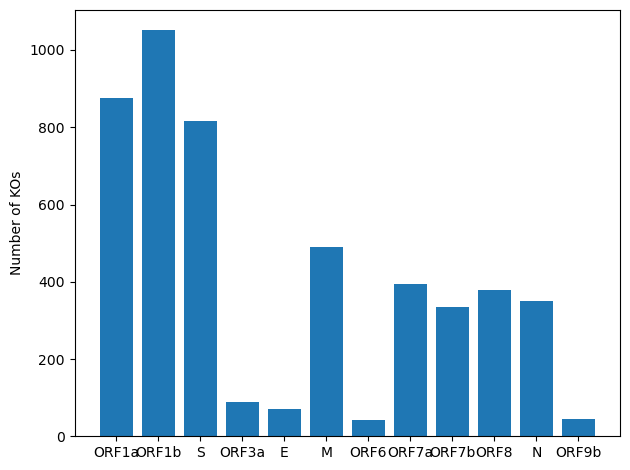

In [6]:
fig, ax = plt.subplots(tight_layout=True)
genes = []
kos = []
lengths = []
for feature in ref.features:
    if feature.type == "CDS":
        name = feature.qualifiers['gene'][0]
        start = feature.location.start
        end = feature.location.end
        length = len(ref.seq[start:end].translate(to_stop=True))
        ko = df[name+'_ko']
        genes.append(name)
        kos.append(len(ko[ko=='Yes']))
        lengths.append(length)
ax.bar(genes,np.asarray(kos))
ax.set_ylabel('Number of KOs')
#fig.savefig('../figs/gaps_gene.pdf',dpi=300)

AttributeError: 'numpy.ndarray' object has no attribute 'bar'

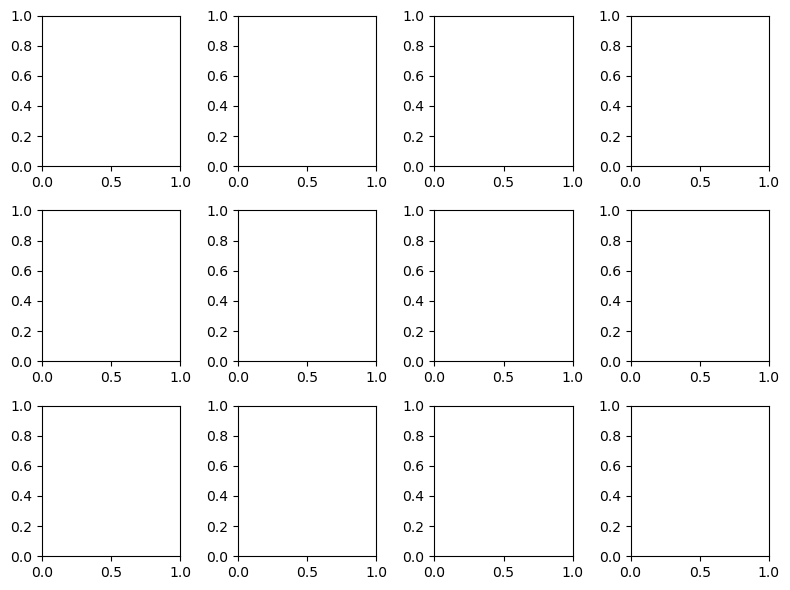

In [17]:
fig, ax = plt.subplots(ncols=4,nrows=3,figsize=(8,6),tight_layout=True)
count = 0
for feature in ref.features:
    if feature.type == "CDS":
        name = feature.qualifiers['gene'][0]
        ko = df[name+'_maxDeletion']
        row = int(np.floor(count/4))
        col = count % 4
        values, counts = np.unique(ko,return_counts=True)
        genes.append(name)
        kos.append(counts[1])
        ax.bar(genes,kos)
        ax.set_ylabel('Number of KOs')
        
        count +=1

In [39]:
#### FIX GAPS to not count end or beginning